<a href="https://colab.research.google.com/github/donggale72/10000.html/blob/main/ch04_05_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.05 Wave Net

* 날짜:
* 이름:

## 학습내용
    - Audio data에 대해 이해한다.
    - 머신러닝 방법으로 접근하여 문제를 해결해 본다.
    - 딥러닝 네트워크를 이용해 문제를 해결한다.
    - waveNet, yamNet 등 딥러닝 알고리즘을 적용한다.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys, os
sys.path.append('/content/drive/MyDrive/scripts')
from lib import *

In [ ]:

import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 데이터셋 - Kaggle GTZAN Dataset 
---

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification



### **| kaggle 데이터 연동**


1. kaggle 로그인 - my account - API Create New Api Token - `kaggle.json` 파일 다운로드
2. Drive에 저장해 놓는것을 권장
3. kaggle 패키지 다운로드
```
! pip install kaggle
```
4. 권한 변경
```
! chmod 600 `드라이브 파일 경로`
```
5. `~/` 위치에 복사
```
! cp `드라이브 파일 경로` ~/.kaggle/
```

6. 데이터셋 다운로드
```
! kaggle datasets download 데이터주소
```

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
#! chmod 600 /content/drive/MyDrive/script/kaggle.json

In [ ]:
! cp /content/drive/MyDrive/scripts/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip /content/gtzan-dataset-music-genre-classification.zip

Archive:  /content/gtzan-dataset-music-genre-classification.zip
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### **| EDA**

In [ ]:
df = pd.read_csv('/content/Data/features_30_sec.csv')
print(df.shape)
df.head()

(1000, 60)


filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  rolloff_mean  \
0              2002.449060            85882.761315   3805.839606   
1              2039.036516           213843.755497   3550.522098   
2              1747.702312            76254.192257   3042.260232   
3              1596.412872           166441.494769   2184.745799   
4              1748.172116            88445.209036   3579.757627   

    rolloff_var  zero_crossing_rate_mean  zero_crossing_rate_var  \
0  9.015054e+05                 0.083045                0.000767   
1  2.977893e+06                 0.056040                0.001448   
2  7.840345e+05                 0.076291                0.001007   
3  1.493194e+06                 0.033309                0.000423   
4  1.572978e+06                 0.101461                0.001954   

   harmony_mean  harmony_var  perceptr_mean  perceptr_var       tempo  \
0 -4.529724e-05     0.008172       0.000008      0.005698  123.046875   
1  1.395807e-04     0.005099      -0.000178      0.003063   67.999589   
2  2.105576e-06     0.016342      -0.000019      0.007458  161.499023   
3  4.583644e-07     0.019054      -0.000014      0.002712   63.024009   
4 -1.756129e-05     0.004814      -0.000010      0.003094  135.999178   

   mfcc1_mean    mfcc1_var  mfcc2_mean   mfcc2_var  mfcc3_mean   mfcc3_var  \
0 -113.570648  2564.207520  121.571793  295.913818  -19.168142  235.574432   
1 -207.501694  7764.555176  123.991264  560.259949    8.955127  572.810913   
2  -90.722595  3319.044922  140.446304  508.765045  -29.093889  411.781219   
3 -199.544205  5507.517090  150.090897  456.505402    5.662678  257.161163   
4 -160.337708  5195.291992  126.219635  853.784729  -35.587811  333.792938   

   mfcc4_mean   mfcc4_var  mfcc5_mean   mfcc5_var  mfcc6_mean   mfcc6_var  \
0   42.366421  151.106873   -6.364664  167.934799   18.623499   89.180840   
1   35.877647  264.506104    2.907320  279.932922   21.510466  156.477097   
2   31.684334  144.090317  -13.984504  155.493759   25.764742   74.548401   
3   26.859079  158.267303    1.771399  268.034393   14.234031  126.794128   
4   22.148071  193.456100  -32.478600  336.276825   10.852294  134.831573   

   mfcc7_mean   mfcc7_var  mfcc8_mean   mfcc8_var  mfcc9_mean   mfcc9_var  \
0  -13.704891   67.660492   15.343150   68.932579  -12.274110   82.204201   
1   -8.560436  200.849182   23.370686  142.555954  -10.099661  166.108521   
2  -13.664875  106.981827   11.639934  106.574875  -11.783643   65.447945   
3   -4.832006  155.912079    9.286494   81.273743   -0.759186   92.114090   
4  -23.352329   93.257095    0.498434  124.672127  -11.793437  130.073349   

   mfcc10_mean  mfcc10_var  mfcc11_mean  mfcc11_var  mfcc12_mean  mfcc12_var  \
0    10.976572   63.386311    -8.326573   61.773094     8.803792   51.244125   
1    11.900497  104.358612    -5.555639  105.173630     5.376327   96.197212   
2     9.718760   67.908859   -13.133803   57.781425     5.791199   64.480209   
3     8.137607   71.314079    -3.200653  110.236687     6.079319   48.251999   
4     1.207256   99.675575   -13.088418   80.254066    -2.813867   86.430626   

   mfcc13_mean  mfcc13_var  mfcc14_mean  mfcc14_var  

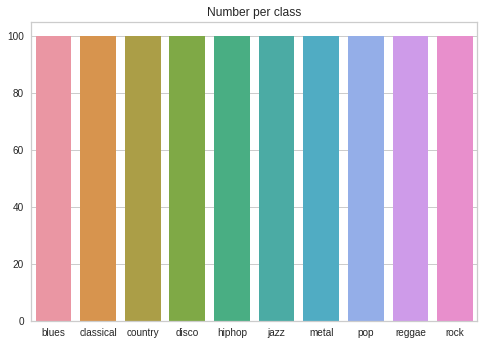

In [ ]:
class_count = df['label'].value_counts()
plt.title('Number per class')
_=sns.barplot(x=class_count.index, y=class_count.values)

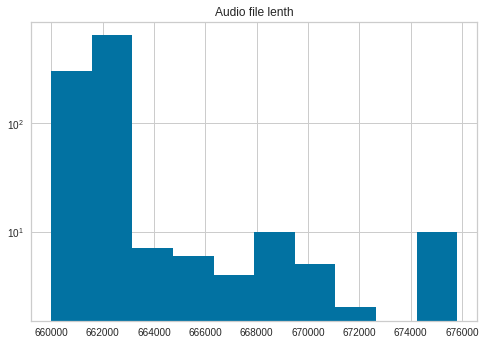

In [ ]:
plt.title('Audio file lenth')
_=plt.hist(df['length'], log=True)

특성 개수 57


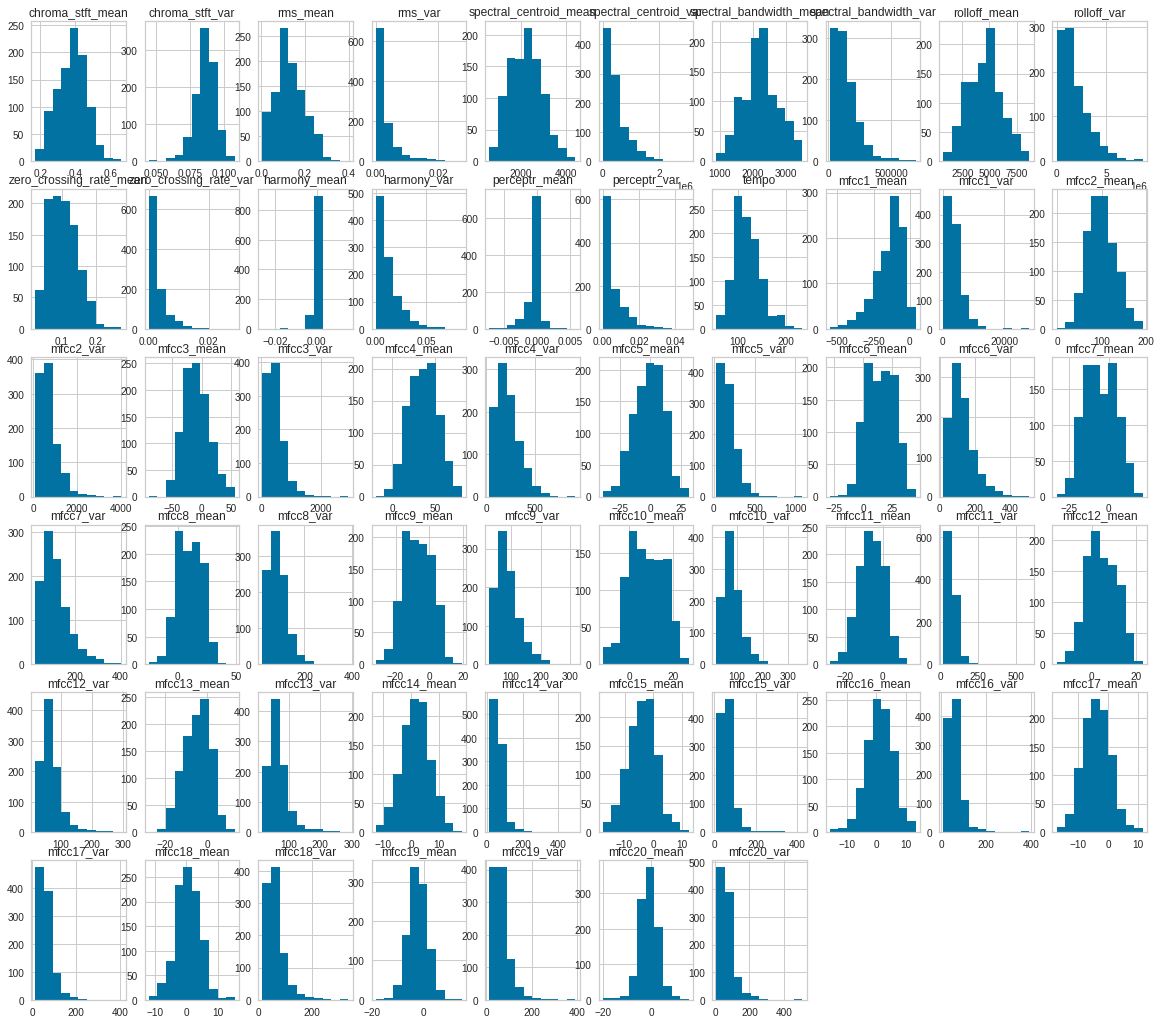

In [ ]:
print('특성 개수', len(df.columns[2:-1]))
plt.figure(figsize=(20,18))
for i, col in enumerate(df.columns[2: -1]):
  plt.subplot(6,10, i+1)
  plt.title(col)
  plt.hist(df[col])

## 머신러닝 접근 방법 (features)
---

### **| 파라미터 추가**


In [ ]:
df

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0    blues.00000.wav  661794          0.350088         0.088757  0.130228   
1    blues.00001.wav  661794          0.340914         0.094980  0.095948   
2    blues.00002.wav  661794          0.363637         0.085275  0.175570   
3    blues.00003.wav  661794          0.404785         0.093999  0.141093   
4    blues.00004.wav  661794          0.308526         0.087841  0.091529   
..               ...     ...               ...              ...       ...   
995   rock.00095.wav  661794          0.352063         0.080487  0.079486   
996   rock.00096.wav  661794          0.398687         0.075086  0.076458   
997   rock.00097.wav  661794          0.432142         0.075268  0.081651   
998   rock.00098.wav  661794          0.362485         0.091506  0.083860   
999   rock.00099.wav  661794          0.358401         0.085884  0.054454   

      rms_var  spectral_centroid_mean  spectral_centroid_var  \
0    0.002827             1784.165850          129774.064525   
1    0.002373             1530.176679          375850.073649   
2    0.002746             1552.811865          156467.643368   
3    0.006346             1070.106615          184355.942417   
4    0.002303             1835.004266          343399.939274   
..        ...                     ...                    ...   
995  0.000345             2008.149458          282174.689224   
996  0.000588             2006.843354          182114.709510   
997  0.000322             2077.526598          231657.968040   
998  0.001211             1398.699344          240318.731073   
999  0.000336             1609.795082          422203.216152   

     spectral_bandwidth_mean  spectral_bandwidth_var  rolloff_mean  \
0                2002.449060            85882.761315   3805.839606   
1                2039.036516           213843.755497   3550.522098   
2                1747.702312            76254.192257   3042.260232   
3                1596.412872           166441.494769   2184.745799   
4                1748.172116            88445.209036   3579.757627   
..                       ...                     ...           ...   
995              2106.541053            88609.749506   4253.557033   
996              2068.942009            82426.016726   4149.338328   
997              1927.293153            74717.124394   4031.405321   
998              1818.450280           109090.207161   3015.631004   
999              1797.213044           120115.632927   3246.908930   

      rolloff_var  zero_crossing_rate_mean  zero_crossing_rate_var  \
0    9.015054e+05                 0.083045                0.000767   
1    2.977893e+06                 0.056040                0.001448   
2    7.840345e+05                 0.076291                0.001007   
3    1.493194e+06                 0.033309                0.000423   
4    1.572978e+06                 0.101461                0.001954   
..            ...                      ...                     ...   
995  1.222421e+06                 0.089227                0.001305   
996  1.046621e+06                 0.097664                0.000868   
997  8.042154e+05                 0.121823                0.001697   
998  1.332712e+06                 0.048724                0.000808   
999  1.753476e+06                 0.076305                0.002171   

     harmony_mean  harmony_var  perceptr_mean  perceptr_var       tempo  \
0   -4.529724e-05     0.008172       0.000008      0.005698  123.046875   
1    1.395807e-04     0.005099      -0.000178      0.003063   67.999589   
2    2.105576e-06     0.016342      -0.000019      0.007458  161.499023   
3    4.583644e-07     0.019054      -0.000014      0.002712   63.024009   
4   -1.756129e-05     0.004814      -0.000010      0.003094  135.999178   
..            ...          ...            ...           ...         ...   
995  1.926835e-06     0.004594      -0.000012      0.000681  103.359375   
996 -1.406142e-06     0.003981      

In [ ]:
import librosa

new_arr = np.zeros([1000, 8])
for i, (f_name, label) in enumerate(zip(df['filename'], df['label'])):
  if i%10==0: print(f'*{i}')
  if f_name == 'jazz.00054.wav': continue
  dir_path =f'/content/Data/genres_original/{label}'
  f_path = f'{dir_path}/{f_name}'
  y, sr = librosa.load(f_path)
  chroma_cens= librosa.feature.chroma_cens(y=y, sr=sr)
  spectral_contrast =librosa.feature.spectral_contrast(y=y, sr=sr)
  spectral_flatness = librosa.feature.spectral_flatness(y=y)
  tonnetz= librosa.feature.tonnetz(y=y, sr=sr)

  chroma_cens_mean= np.mean(chroma_cens)
  chroma_cens_var= np.var(chroma_cens)
  spectral_contrast_mean=np.mean(spectral_contrast)
  spectral_contrast_var= np.var(spectral_contrast)
  spectral_flatness_mean=np.mean(spectral_flatness)
  spectral_flatness_var = np.var(spectral_flatness)
  tonnetz_mean = np.mean(tonnetz)
  tonnetz_var = np.var(tonnetz)

  new_arr[i, 0]=chroma_cens_mean
  new_arr[i, 1]=chroma_cens_var
  new_arr[i, 2]=spectral_contrast_mean
  new_arr[i, 3]=spectral_contrast_var
  new_arr[i, 4]=spectral_flatness_mean
  new_arr[i, 5]=spectral_flatness_var
  new_arr[i, 6]=tonnetz_mean
  new_arr[i, 7]=tonnetz_var

new_arr.shape




*0
*10
*20
*30
*40
*50
*60
*70
*80
*90
*100
*110
*120
*130
*140
*150
*160
*170
*180
*190
*200
*210
*220
*230
*240
*250
*260
*270
*280
*290
*300
*310
*320
*330
*340
*350
*360
*370
*380
*390
*400
*410
*420
*430
*440
*450
*460
*470
*480
*490
*500
*510
*520
*530
*540
*550
*560
*570
*580
*590
*600
*610
*620
*630
*640
*650
*660
*670
*680
*690
*700
*710
*720
*730
*740
*750
*760
*770
*780
*790
*800
*810
*820
*830
*840
*850
*860
*870
*880
*890
*900
*910
*920
*930
*940
*950
*960
*970
*980
*990


(1000, 8)

In [ ]:
df.shape, new_arr.shape

((1000, 60), (1000, 8))

In [ ]:
df['chroma_cens_mean']=new_arr[:, 0]
df['chroma_cens_var']=new_arr[:, 1]
df['spectral_contrast_mean']=new_arr[:, 2]
df['spectral_contrast_var']=new_arr[:, 3]
df['spectral_flatness_mean']=new_arr[:, 4]
df['spectral_flatness_var']=new_arr[:, 5]
df['tonnetz_mean']=new_arr[:, 6]
df['tonnetz_var']=new_arr[:, 7]

In [ ]:
print(df.shape)
df.head()

(1000, 68)


filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc20_var  label  \
0              2002.449060            85882.761315  ...   46.936035  blues   
1              2039.036516           213843.755497  ...   45.786282  blues   
2              1747.702312            76254.192257  ...   30.573025  blues   
3              1596.412872           166441.494769  ...   31.949339  blues   
4              1748.172116            88445.209036  ...   55.195160  blues   

   chroma_cens_mean  chroma_cens_var  spectral_contrast_mean  \
0          0.272036         0.009330               20.526699   
1          0.260980         0.015223               20.676128   
2          0.262627         0.014360               22.197517   
3          0.226383         0.032084               21.426268   
4          0.259550         0.015967               21.466338   

   spectral_contrast_var  spectral_flatness_mean  spectral_flatness_var  \
0              76.741834                0.004498               0.000030   
1              67.851520                0.002298               0.000024   
2              76.130717                0.002631               0.000011   
3              63.384626                0.000954               0.000003   
4              62.986186                0.003238               0.000019   

   tonnetz_mean  tonnetz_var  
0      0.007162     0.004417  
1      0.029154     0.004762  
2      0.024264     0.010511  
3      0.026562     0.017854  
4     -0.020919     0.010125  

[5 rows x 68 columns]

In [ ]:
print(df.shape)
df.head()

(1000, 68)


filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc20_var  label  \
0              2002.449060            85882.761315  ...   46.936035  blues   
1              2039.036516           213843.755497  ...   45.786282  blues   
2              1747.702312            76254.192257  ...   30.573025  blues   
3              1596.412872           166441.494769  ...   31.949339  blues   
4              1748.172116            88445.209036  ...   55.195160  blues   

   chroma_cens_mean  chroma_cens_var  spectral_contrast_mean  \
0          0.272036         0.009330               20.526699   
1          0.260980         0.015223               20.676128   
2          0.262627         0.014360               22.197517   
3          0.226383         0.032084               21.426268   
4          0.259550         0.015967               21.466338   

   spectral_contrast_var  spectral_flatness_mean  spectral_flatness_var  \
0              76.741834                0.004498               0.000030   
1              67.851520                0.002298               0.000024   
2              76.130717                0.002631               0.000011   
3              63.384626                0.000954               0.000003   
4              62.986186                0.003238               0.000019   

   tonnetz_mean  tonnetz_var  
0      0.007162     0.004417  
1      0.029154     0.004762  
2      0.024264     0.010511  
3      0.026562     0.017854  
4     -0.020919     0.010125  

[5 rows x 68 columns]

In [ ]:
df.loc[554]

filename                  jazz.00054.wav
length                            662112
chroma_stft_mean                 0.27827
chroma_stft_var                 0.083737
rms_mean                        0.162394
                               ...      
spectral_contrast_var                0.0
spectral_flatness_mean               0.0
spectral_flatness_var                0.0
tonnetz_mean                         0.0
tonnetz_var                          0.0
Name: 554, Length: 68, dtype: object

In [ ]:
df=df.drop([554])

In [ ]:
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc20_var  label  \
0              2002.449060            85882.761315  ...   46.936035  blues   
1              2039.036516           213843.755497  ...   45.786282  blues   
2              1747.702312            76254.192257  ...   30.573025  blues   
3              1596.412872           166441.494769  ...   31.949339  blues   
4              1748.172116            88445.209036  ...   55.195160  blues   

   chroma_cens_mean  chroma_cens_var  spectral_contrast_mean  \
0          0.272036         0.009330               20.526699   
1          0.260980         0.015223               20.676128   
2          0.262627         0.014360               22.197517   
3          0.226383         0.032084               21.426268   
4          0.259550         0.015967               21.466338   

   spectral_contrast_var  spectral_flatness_mean  spectral_flatness_var  \
0              76.741834                0.004498               0.000030   
1              67.851520                0.002298               0.000024   
2              76.130717                0.002631               0.000011   
3              63.384626                0.000954               0.000003   
4              62.986186                0.003238               0.000019   

   tonnetz_mean  tonnetz_var  
0      0.007162     0.004417  
1      0.029154     0.004762  
2      0.024264     0.010511  
3      0.026562     0.017854  
4     -0.020919     0.010125  

[5 rows x 68 columns]

### **| 전처리**


In [ ]:
from sklearn import preprocessing

le= preprocessing.LabelEncoder()
df['le_label'] = le.fit_transform(df['label'])
print(le.classes_)
df.head()

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  rolloff_mean  \
0              2002.449060            85882.761315   3805.839606   
1              2039.036516           213843.755497   3550.522098   
2              1747.702312            76254.192257   3042.260232   
3              1596.412872           166441.494769   2184.745799   
4              1748.172116            88445.209036   3579.757627   

    rolloff_var  zero_crossing_rate_mean  zero_crossing_rate_var  \
0  9.015054e+05                 0.083045                0.000767   
1  2.977893e+06                 0.056040                0.001448   
2  7.840345e+05                 0.076291                0.001007   
3  1.493194e+06                 0.033309                0.000423   
4  1.572978e+06                 0.101461                0.001954   

   harmony_mean  harmony_var  perceptr_mean  perceptr_var       tempo  \
0 -4.529724e-05     0.008172       0.000008      0.005698  123.046875   
1  1.395807e-04     0.005099      -0.000178      0.003063   67.999589   
2  2.105576e-06     0.016342      -0.000019      0.007458  161.499023   
3  4.583644e-07     0.019054      -0.000014      0.002712   63.024009   
4 -1.756129e-05     0.004814      -0.000010      0.003094  135.999178   

   mfcc1_mean    mfcc1_var  mfcc2_mean   mfcc2_var  mfcc3_mean   mfcc3_var  \
0 -113.570648  2564.207520  121.571793  295.913818  -19.168142  235.574432   
1 -207.501694  7764.555176  123.991264  560.259949    8.955127  572.810913   
2  -90.722595  3319.044922  140.446304  508.765045  -29.093889  411.781219   
3 -199.544205  5507.517090  150.090897  456.505402    5.662678  257.161163   
4 -160.337708  5195.291992  126.219635  853.784729  -35.587811  333.792938   

   mfcc4_mean   mfcc4_var  mfcc5_mean   mfcc5_var  mfcc6_mean   mfcc6_var  \
0   42.366421  151.106873   -6.364664  167.934799   18.623499   89.180840   
1   35.877647  264.506104    2.907320  279.932922   21.510466  156.477097   
2   31.684334  144.090317  -13.984504  155.493759   25.764742   74.548401   
3   26.859079  158.267303    1.771399  268.034393   14.234031  126.794128   
4   22.148071  193.456100  -32.478600  336.276825   10.852294  134.831573   

   mfcc7_mean   mfcc7_var  mfcc8_mean   mfcc8_var  mfcc9_mean   mfcc9_var  \
0  -13.704891   67.660492   15.343150   68.932579  -12.274110   82.204201   
1   -8.560436  200.849182   23.370686  142.555954  -10.099661  166.108521   
2  -13.664875  106.981827   11.639934  106.574875  -11.783643   65.447945   
3   -4.832006  155.912079    9.286494   81.273743   -0.759186   92.114090   
4  -23.352329   93.257095    0.498434  124.672127  -11.793437  130.073349   

   mfcc10_mean  mfcc10_var  mfcc11_mean  mfcc11_var  mfcc12_mean  mfcc12_var  \
0    10.976572   63.386311    -8.326573   61.773094     8.803792   51.244125   
1    11.900497  104.358612    -5.555639  105.173630     5.376327   96.197212   
2     9.718760   67.908859   -13.133803   57.781425     5.791199   64.480209   
3     8.137607   71.314079    -3.200653  110.236687     6.079319   48.251999   
4     1.207256   99.675575   -13.088418   80.254066    -2.813867   86.430626   

   mfcc13_mean  mfcc13_var  mfcc14_mean  mfcc14_var  

In [ ]:
df=df.drop([554])
df.shape

In [ ]:
selected= df.drop(columns=['filename', 'length', 'label', 'le_label'])
selected2=df['le_label']
selected.shape, selected2.shape

((999, 57), (999,))

In [ ]:
x= df.drop(columns=['filename', 'length', 'label', 'le_label'])
y=df['le_label']
selected.shape, selected2.shape

((999, 57), (999,))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.1, stratify=y, random_state=0)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (899, 57) (899,)
test (100, 57) (100,)


In [ ]:
sc=preprocessing.StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train.shape, x_test.shape

((899, 57), (100, 57))


# 추가된 데이터 머신러닝 돌리기
  # pycaret

# 추가된 데이터 딥러닝 돌리기

In [ ]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=14225a7ebea146ee8636c8c4e05ee627ad75c4195c1ddb93b15d2048d81b935b
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 4.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [ ]:
import sklearn
sklearn.__version__
import sys
sys.version

'3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]'

In [ ]:
!pip install pycaret
!pip install Jinja2==3.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 4.3 MB/s 
     |████████████████████████████████| 2.0 MB 75.5 MB/s 
     |████████████████████████████████| 17.0 MB 13.1 MB/s 
     |████████████████████████████████| 10.4 MB 26.3 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 262 kB 51.2 MB/s 
     |████████████████████████████████| 25.9 MB 1.3 MB/s 
     |████████████████████████████████| 3.3 MB 71.9 MB/s 
     |████████████████████████████████| 1.7 MB 52.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 167 kB 83.7 MB/s 
     |████████████████████████████████| 1.3 MB 80.9 MB/s 
     |████████████████████████████████| 636 kB 74.9 MB/s 
     |███████████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 4.2 MB/s 
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.0.1 which is incompatible.


In [ ]:
from pycaret.utils import enable_colab
enable_colab()
from pycaret.regression import *

Colab mode enabled.


In [ ]:
df_train = df[selected+selected2].iloc[:799]
x = df_train[selected]
y = df_train['le_label']
X_test = df[selected].iloc[799:]
x.shape, y.shape

ValueError: ignored

In [ ]:
df_train.shape, X_test.shape

In [ ]:
data=setup(data=df_train, target='le_label', train_size=0.8)

In [ ]:
compare_models(sort='RMSLE')

In [ ]:
lgb=create_model('gbr')

In [ ]:
lgb_tuned=tune_model(lgb, optimize='adam')
lgb_tuned

In [ ]:
blender=blend_models(estimator_list=compare_models(n_select=3,
                                                   sort='adam'))

In [ ]:
final=finalize_model(blender)

In [ ]:
y_pred=predict_model(blender, data=X_test)
y_pred

In [ ]:
y_pred['le_label']

### **| 학습 - XGBoost**

In [ ]:
! pip install xgboost -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xgboost import XGBClassifier
xgb= XGBClassifier(n_estimators=1000)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Test Acc 0.79


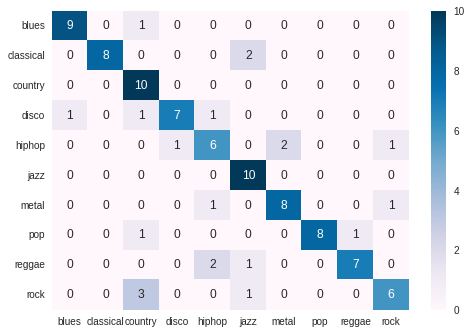

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def show_result(model, x_test, y_test):
  y_pred= model.predict(x_test)
  print('Test Acc', accuracy_score(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  _=sns.heatmap(cm, annot=True, cmap='PuBu', xticklabels= le.classes_, yticklabels=le.classes_)
show_result(xgb, x_test, y_test)


### **| 학습 - DNN**

In [ ]:
from tensorflow.keras import models, layers, utils
from tensorflow.keras.layers import Dropout

def build_model():
  x = layers.Input(shape=(57,))
  y = layers.Dense(114, activation='relu')(x)
  y = layers.Dense(57, activation='relu')(y)
  y = Dropout(0.5)(y)
  y = layers.Dense(10, activation='softmax', name='OutputLayer')(y)
  model = models.Model(x, y)
  return model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 57)]              0         
                                                                 
 dense_5 (Dense)             (None, 114)               6612      
                                                                 
 dense_6 (Dense)             (None, 57)                6555      
                                                                 
 dropout_3 (Dropout)         (None, 57)                0         
                                                                 
 OutputLayer (Dense)         (None, 10)                580       
                                                                 
Total params: 13,747
Trainable params: 13,747
Non-trainable params: 0
_________________________________________________________________


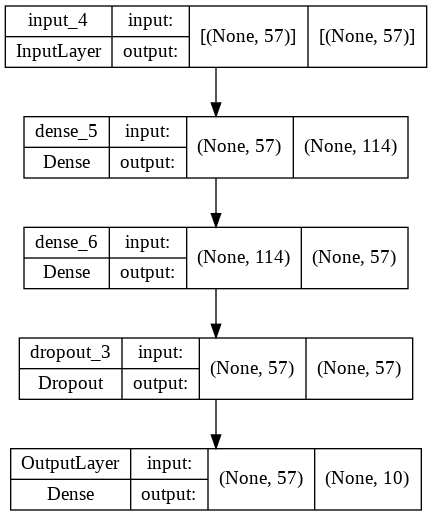

In [ ]:
model = build_model()
model.summary()
utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=100, batch_size=30, validation_split=0.1)

Epoch 1/100
27/27 [==============================] - 1s 7ms/step - loss: 2.2227 - accuracy: 0.1990 - val_loss: 1.9422 - val_accuracy: 0.3333
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 1.8395 - accuracy: 0.3461 - val_loss: 1.6923 - val_accuracy: 0.4333
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 1.6139 - accuracy: 0.4240 - val_loss: 1.5174 - val_accuracy: 0.4667
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 1.4194 - accuracy: 0.4957 - val_loss: 1.4253 - val_accuracy: 0.5111
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 1.3065 - accuracy: 0.5439 - val_loss: 1.3616 - val_accuracy: 0.5333
Epoch 6/100
27/27 [==============================] - 0s 3ms/step - loss: 1.2157 - accuracy: 0.5686 - val_loss: 1.2882 - val_accuracy: 0.5444
Epoch 7/100
27/27 [==============================] - 0s 3ms/step - loss: 1.1927 - accuracy: 0.5847 - val_loss: 1.2839 - val_accuracy: 0.5222
Epoch 8/100
2

In [ ]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.7188 - accuracy: 0.8100


[0.7188183665275574, 0.8100000023841858]

In [ ]:
y_pred = model.predict(x_test)
print(y_test.shape, y_pred.shape)
# print(y_test[0], y_pred[0])
# 원핫 -> 라벨
y_pred = np.argmax(y_pred, axis=1)
# y_test = np.argmax(y_test, axis=1)
print(y_test.shape, y_pred.shape)
# print(y_test[0], y_pred[0])

(100,) (100, 10)
(100,) (100,)


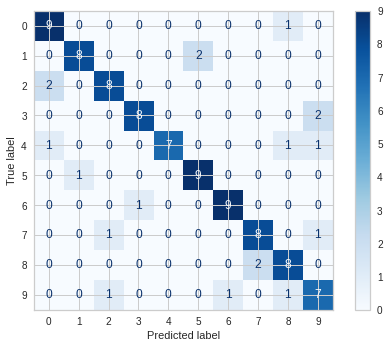

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
#print(cm)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

## 딥러닝 접근 방법(Audio 원 데이터)
---

In [ ]:
csv_path= '/content/Data/features_30_sec.csv'
data_dir= '/content/Data/genres_original'
class_dict ={
    'blues':0,
    'classical': 1,
    'country': 2,
    'disco': 3,
    'hiphop': 4,
    'jazz': 5,
    'metal': 6,
    'pop':7,
    'reggae': 8,
    'rock': 9
}

def df_process(csv_path, data_dir, class_dict):
  df = pd.read_csv(csv_path)
  df= df.drop(index=[554])
  df['fillepath'] =df.apply(lambda x: f'{data_dir}/{x["label"]}/{x["filename"]}', axis=1)
  df['label'] = df['label'].map(class_dict)
  return list(df['fillepath']), list(df['label'])

paths, labels = df_process(csv_path, data_dir, class_dict)
print(len(paths), paths[:2])
print(len(labels), labels[: 2])


999 ['/content/Data/genres_original/blues/blues.00000.wav', '/content/Data/genres_original/blues/blues.00001.wav']
999 [0, 0]


In [ ]:
import tensorflow_hub as hub

yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

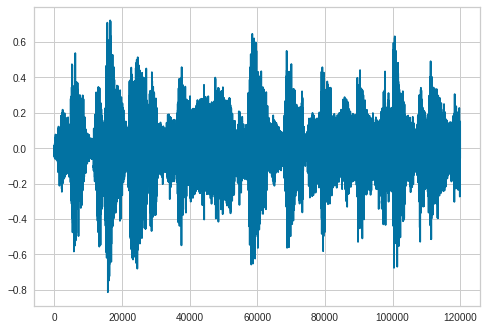

In [ ]:
def path2wav(path, label, mx_len= 120000):
  f = tf.io.read_file(path)
  wav, sr = tf.audio.decode_wav(f, desired_channels=1)
  wav =tf.squeeze(wav, axis=-1)
  wav =wav[: mx_len]
  return wav, label

wav, label = path2wav(paths[0], labels[0])
plt.plot(wav)

from IPython import display
display.Audio(wav, rate =16000)

In [ ]:
wav, label = path2wav(paths[0], labels[0])
scores, embeddings, log_mel_spectrogram = yamnet(wav)
embeddings.shape

TensorShape([15, 1024])

In [ ]:
def wav2embedding(wav, label):
  _, embedding, _ = yamnet(wav)
  return embedding, label

def ds_generator(paths, labels, batch_size=10, train= True):
  ds = tf.data.Dataset.from_tensor_slices((paths, labels))
  ds = ds.map(path2wav)
  ds= ds.map(wav2embedding)
  if train:
    ds = ds.shuffle(buffer_size = 1000)
  ds = ds.cache().prefetch(tf.data.AUTOTUNE)
  ds = ds.batch(batch_size)
  return ds

from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(paths, labels,
                                                                      test_size = 0.1,
                                                                      stratify = labels,
                                                                      random_state=0)

print('train', len(train_paths), len(train_labels))
print('test', len(test_paths), len(test_labels))

train_ds = ds_generator(train_paths, train_labels)
test_ds = ds_generator(test_paths, test_labels, train=False)

train 899 899
test 100 100


In [ ]:
for embeddings, labels in train_ds.take(1):
  print(embeddings.shape, labels)

(10, 15, 1024) tf.Tensor([2 8 4 4 4 4 1 2 5 5], shape=(10,), dtype=int32)


In [ ]:
def create_wavenet_base(x_shape, y_shape):
  model =models.Sequential()
  model.add(layers.Input(shape=x_shape))

  for rate in (1,2,4,8):
    model.add(layers.Conv1D(20, kernel_size=2, activation ='relu',
                            padding = 'causal',
                            dilation_rate=rate))
    
    model.add(layers.AveragePooling1D(100, padding='same'))
    model.add(layers.Conv1D(10, 1, padding = 'same', activation ='relu'))
    model.add(layers.AveragePooling1D(100, padding = 'same'))
    model.add(layers.Conv1D(10,1, padding='same', activation = 'relu'))

    model.add(layers.Reshape((120,)))
    model.add(layers.Dense(10, activation ='softmax'))

    model.compile(optimizer='adam',
                  loss= 'sparse_categorical_crossentropy',
                  metrics=['acc'])
    
    return model

def create_yamnet_base(x_shape, y_shape):
  model =models.Sequential()
  model.add(layers.Input(shape=x_shape))

  model.add(layers.Dense(32, activation = 'relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Reshape((int(15*32),)))
  model.add(layers.Dense(10, activation = 'softmax'))

  model.compile(optimizer='adam',
                loss= 'sparse_categorical_crossentropy',
                metrics=['acc'])
  
  return model

x_shape =(15, 1024)
y_shape =(10)
model = create_yamnet_base(x_shape, y_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 15, 32)            32800     
                                                                 
 dropout_5 (Dropout)         (None, 15, 32)            0         
                                                                 
 reshape_2 (Reshape)         (None, 480)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                4810      
                                                                 
Total params: 37,610
Trainable params: 37,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_ds, epochs=100, validation_data=test_ds)

Epoch 1/100
90/90 [==============================] - 87s 106ms/step - loss: 1.7978 - acc: 0.3749 - val_loss: 1.1368 - val_acc: 0.6200
Epoch 2/100
90/90 [==============================] - 0s 4ms/step - loss: 1.0795 - acc: 0.6196 - val_loss: 0.8397 - val_acc: 0.7000
Epoch 3/100
90/90 [==============================] - 0s 4ms/step - loss: 0.8174 - acc: 0.7119 - val_loss: 0.7783 - val_acc: 0.7300
Epoch 4/100
90/90 [==============================] - 0s 4ms/step - loss: 0.7336 - acc: 0.7542 - val_loss: 0.7188 - val_acc: 0.7500
Epoch 5/100
90/90 [==============================] - 0s 4ms/step - loss: 0.6470 - acc: 0.7664 - val_loss: 0.7014 - val_acc: 0.7600
Epoch 6/100
90/90 [==============================] - 0s 5ms/step - loss: 0.5556 - acc: 0.8042 - val_loss: 0.6790 - val_acc: 0.7800
Epoch 7/100
90/90 [==============================] - 0s 5ms/step - loss: 0.5301 - acc: 0.8187 - val_loss: 0.6724 - val_acc: 0.7900
Epoch 8/100
90/90 [==============================] - 0s 4ms/step - loss: 0.4771 